In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 11:22:50.890669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 11:22:52.477965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 6400
end_idx = 6570
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(170, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(170, 96, 7)
(114240,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(170, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(170, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 11:23:02.155647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 11:23:04.986384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step
CPU time: 3284.3770958159585 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

6/6 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.48382807 0.53448807 0.15233718 ... 0.29466085 0.39132526 0.69778127]
Fitness value of the best solution = 0.04682034113018096


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

6/6 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


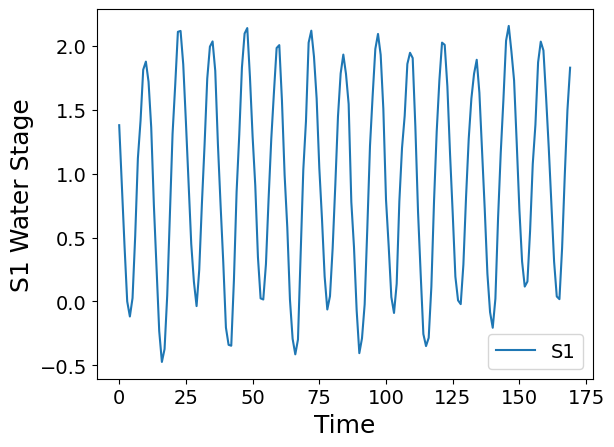

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low10.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.483828,0.534488,0.152337,0.030773,0.522803,0.797716,0.968086,0.587136,0.656330,0.306672,...,0.004828,0.140869,0.573556,0.493006,0.113043,0.708615,0.097339,0.008839,0.842007,0.179415
1,0.953334,0.576765,0.561060,0.014035,0.612720,0.198734,0.495805,0.770014,0.066189,0.370387,...,0.690079,0.051355,0.128732,0.302016,0.277781,0.725136,0.277949,0.902994,0.024800,0.700838
2,0.205468,0.000698,0.270984,0.947326,0.967647,0.767171,0.569337,0.701770,0.706867,0.124413,...,0.133772,0.735647,0.237813,0.572566,0.789403,0.549869,0.814151,0.669996,0.777804,0.401769
3,0.641137,0.855499,0.034946,0.080255,0.560979,0.759487,0.306108,0.170353,0.428862,0.989255,...,0.892304,0.359470,0.099322,0.553989,0.455001,0.711141,0.454013,0.308285,0.656183,0.573057
4,0.007715,0.096215,0.507860,0.445190,0.182446,0.489838,0.051618,0.604957,0.615290,0.340840,...,0.074290,0.632262,0.385664,0.808036,0.916900,0.018782,0.605335,0.240012,0.977474,0.803220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.170025,0.567228,0.447339,0.979153,0.640397,0.511364,0.395403,0.103809,0.325021,0.835476,...,0.543014,0.311344,0.872808,0.385243,0.610946,0.472322,0.056254,0.502242,0.805372,0.735548
166,0.946601,0.153091,0.219254,0.784123,0.241427,0.273043,0.239863,0.271332,0.211293,0.427987,...,0.349456,0.896684,0.810980,0.637637,0.309141,0.674842,0.245614,0.741149,0.200282,0.863993
167,0.726259,0.231586,0.724297,0.635270,0.813966,0.888640,0.532666,0.456189,0.009630,0.662041,...,0.609573,0.605808,0.971947,0.783746,0.383802,0.788241,0.682099,0.981600,0.394809,0.272528
168,0.729993,0.982287,0.322250,0.811039,0.882401,0.806223,0.728888,0.001266,0.655656,0.804986,...,0.836696,0.724666,0.907157,0.117110,0.956434,0.582709,0.834170,0.711603,0.738266,0.137014


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low10.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.379534,1.651614,1.456487,1.512231,1.000360,1.228107,1.105473,1.172815,0.401110,0.397170,...,1.651133,1.713664,1.891272,1.873923,1.813654,1.936025,2.006660,1.991288,1.948230,2.089809
1,0.907911,1.240092,0.975389,0.906331,0.506792,0.626420,0.634702,0.561441,0.121250,0.397463,...,1.876918,2.008183,2.026147,2.069983,2.093426,2.196728,1.810830,1.942402,1.958747,1.979300
2,0.433427,0.542873,0.566713,0.474720,0.071195,0.162826,0.169780,0.145574,-0.050822,-0.061329,...,2.099289,2.138989,1.851903,1.799354,2.001880,2.003172,1.486315,1.564236,1.660232,1.641637
3,0.000488,0.056982,0.081603,0.015829,-0.117670,0.009418,-0.009887,-0.075778,0.150453,0.248880,...,1.840785,1.900032,1.402850,1.618616,1.517420,1.583371,0.932416,1.062959,1.190175,1.184876
4,-0.117519,-0.028359,0.007397,-0.059742,0.063493,-0.167109,0.151288,0.068649,0.579949,0.643806,...,1.518018,1.570336,0.876731,0.934404,1.095221,1.036459,0.595414,0.886896,0.855040,0.816581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.017955,-0.101057,0.008860,-0.039539,0.348411,0.221861,0.309859,0.346477,1.074635,0.909093,...,1.387562,1.406979,0.907017,1.004375,1.178949,1.163150,0.542229,0.555945,0.768357,0.738132
166,0.418637,0.383076,0.438664,0.435631,0.908828,0.625459,0.876681,0.922655,1.414460,1.458664,...,1.090939,1.153851,0.569094,0.744102,0.695837,0.664661,0.392084,0.546605,0.512712,0.485622
167,0.986821,0.744452,0.988167,0.991731,1.469206,1.353623,1.408472,1.509017,1.967467,1.716903,...,0.666626,0.619074,0.404751,0.596247,0.602158,0.529502,0.447248,0.646282,0.647969,0.615607
168,1.497902,1.654573,1.445656,1.525569,1.879218,1.741609,1.752697,1.884058,2.148452,2.039673,...,0.497309,0.513477,0.489222,0.856484,0.571334,0.569209,0.829910,0.739920,0.874144,0.910209


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 1012, areas: 150.55681054645174


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

6/6 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 2813, areas: 719.9855391146848
